# Sequence labelling (POS tagging) with RNNs

Followed steps:

*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the model
*   Evaluate your best model
*   Analyze the errors of your model

**Corpora**:
Ignore the numeric value in the third column, use only the words/symbols and its label (use only the first two columns).
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip 

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Architectures implemented:**

1) BiLSTM + FC.

2) BiGRU + FC.

3) BiLSTMx2 + FC.

4) BiLSTM + FC + CRF.



# Libraries and fixed seed:

In [ ]:
import math
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim, utils
import torch.nn.functional as F

# function taken from ML4CV course (Prof. Samuele Salti) notebooks:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use. 
    """
    # Add comment for each random seed
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False  
    # benchmark = False means that cuda doesn't look for the optimal algorithm for your hardware, 
    # so it become slower but you need it for removing randomness.
    # But remember that it has this price, so do it only for fast experiments.

    torch.backends.cudnn.deterministic = True


In [ ]:
fix_random(seed=100)

# DATA


## Loading Data:

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'
with urlopen(zipurl) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('dataset_folder')

## Creating DataFrame and split:

Convert the data folder into a pandas DataFrame and split it into training + validation + test sets.

Splits: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

I split the data in sentences AND documents (for the training set):

- I tried both approaches separately and splitting in sentences gave better results. But since the test set will be used only splitted in documents It's better to train the model on both kind of data input, so that it can also learn to exploit the previous sentence to tag the next one, and maybe have better results on the test set.

I split the data in documents for the validation and test sets:

 - I split the validation set in documents give results which I expect to be more similar to the prediction on the test set which must be splitted in documents.

I create the POS tags vocabulary and make sure that there are no POS tags in the test set or in the validation set which are unknown in the training set.

I don't build a corpus vocabulary since I don't need in my code to associate words with a single number and I don't need to build a vocabulary to associate the embedding vector to each word since the embeddding model is efficient to be accessed to and I can directly add the OOV words to it.

I simply use random vectors for OOV words since from the error analysis I don't expect a big improvement using a more complex dealing of them.

In [ ]:
import os
import csv
import pandas as pd
from nltk import tokenize
import nltk
nltk.download('punkt')


df_rows = []
unique_POS = set({})
total_POS = set({})

folder = os.path.join(os.getcwd(), "dataset_folder/dependency_treebank")
i = 0
split = 'train'
for filename in sorted(os.listdir(folder)):
  if i > 99:
    split = 'val'
  if i > 149:
    split = 'test'
  file_path = os.path.join(folder, filename)
  total_words = 0
  with open(file_path, mode='r', encoding='utf-8') as document:
                            doc = pd.read_csv(document, sep='\t',header=None)
                            doc.rename(columns={0: 'word', 1: 'POS', 2:'del'}, inplace=True)
                            doc.drop('del', axis = 'columns' ,inplace= True)
                            words_list = doc['word'].tolist()
                            total_words += len(words_list)
                            POS_list = doc['POS'].tolist()
                            if split == 'train': unique_POS.update(POS_list)  # creating set of POS from training set      
                            total_POS.update(POS_list)  # unique set of POS of all the dataset  
                            df_row = {"split":split, 'doc': i, "type": "document", "words" : words_list, "POS" : POS_list}
                            df_rows.append(df_row)

                            if i<= 99:
                              ########### split into sentences:
                              text = ' '.join(words_list)
                              text = text[:] # i need it as a string type
                              n = 0
                              sentences = tokenize.sent_tokenize(text)
                              for sent in sentences:
                                 spl = sent.split()
                                 pos = POS_list[n:n+len(spl)]
                                 df_row = {"split":split, 'doc': i, "type": "sentence", "words" : spl, "POS" : pos}
                                 n += len(spl)
                                 df_rows.append(df_row)
  i+=1

df = pd.DataFrame(df_rows)
df.head()
if unique_POS == total_POS: print("\n GOOD NEWS: there are no POS tags in the val and train set which are not in the training set.") 
else: print("BAD NEWS: val or test set contains POS tags which are not in the train set")

# create a dictionary that maps POS to indices
POS2idx = {POS : idx for idx,POS in enumerate(unique_POS)}
idx2POS = {idx: POS for idx,POS in enumerate(unique_POS)}


# prepare datasets:
train_df = df.loc[df['split'] == 'train']
val_df = df.loc[df['split'] == 'val']
test_df = df.loc[df['split'] == 'test']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!

 GOOD NEWS: there are no POS tags in the val and train set which are not in the training set.


## Visualizing the data:

In [ ]:
df.head()

,split,doc,type,words,POS
0,train,0,document,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,train,0,sentence,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
2,train,0,sentence,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
3,train,1,document,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
4,train,1,sentence,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."


In [ ]:
print("number of sentences in the training set:", len(train_df))
print("number of sentences in the validation set:",len(val_df))
print("number of sentences in the test set:", len(test_df))

number of sentences in the training set: 2090
number of sentences in the validation set: 50
number of sentences in the test set: 49


In [ ]:
all_POS = list(POS2idx.keys())
dict_all_words = { key : set([]) for key in all_POS}

i = 0
for row in df.iterrows():
  i+=1
  words = row[1]['words']
  POS = row[1]['POS']
  for i in range(len(words)):
      if len(dict_all_words[POS[i]]) < 10:
          dict_all_words[POS[i]].add(words[i])


print("Some examples for each tag:\n")
for key,value in dict_all_words.items():
  print(POS2idx[key],key, "  ->  ", value)


Some examples for each tag:

0 VBP   ->   {'argue', 'expect', 'show', 'have', 'are', 'permit', "'re", 'assume', 'study', 'appear'}
1 NNPS   ->   {'Netherlands', 'Dealers', 'Preferences', 'Securities', 'Springs', 'Machines', 'Instruments', 'Toys', 'Islands', 'Utilities'}
2 LS   ->   {'2', '4', '5', '3', 'b', '1', 'a'}
3 CD   ->   {'61', '1950s', '9.8', '55', '1953', 'billion', '1955', '30', '29', '1956'}
4 $   ->   {'$', 'US$', 'C$'}
5 UH   ->   {'Oh', 'no', 'OK'}
6 RBR   ->   {'less', 'earlier', 'better', 'never', 'more', 'further', 'drearier', 'longer', 'later', 'More'}
7 VBD   ->   {'said', 'reported', 'stopped', 'heard', 'studied', 'worked', 'were', 'led', 'was', 'explained'}
8 WRB   ->   {'When', 'Why', 'how', 'whereby', 'How', 'Where', 'why', 'where', 'whenever', 'when'}
9 -LRB-   ->   {'-LRB-', '-LCB-'}
10 POS   ->   {"'s", "'"}
11 MD   ->   {'will', 'can', 'should', 'could', 'ca', 'may', 'might', "'d", 'must', 'would'}
12 PRP$   ->   {'his', 'their', 'your', 'its', 'Their', 'her

## Dealing with imbalanced data:




## Weighted loss.

Basic idea from the paper: "Class-Balanced Loss Based on Effective Number of Samples".
I've applied the technique based on the frequency but it wasn't effective. 

Probably the reason is that in this task the frequency is not the only matter: there are classes which are frequent but which have a lot of different words! 
I call the "ambiguity" = the number of different words belonging to the class.
(or better I call it "intra_ambiguity" to distinguish it to the "inter_ambiguity").
So it seems reasonable to compute the weights depending on the inverse of the ratio frequency/ambiguity. I implemented the weighted loss based on this ratio, but it tourned out to not be so reliable, maybe because the support changes too much between classes.

So I implemented a weighted loss manually deciding which classes are the most difficult to be classified: the ones with higher "inter ambiguity" = high between classes which intersection is not empty or/and which words have similar shapes, for instance the classes "NNPS" and "NNS".

In [ ]:
############### COMPUTING SUPPORT AND AMBIGUITY FOR EACH CLASS:
def compute_ambiguity_support(df,POS2idx):
    all_POS = list(POS2idx.keys())
    dict_ambiguity_support = { key : [set([]),0] for key in all_POS}

    i = 0
    for row in train_df.iterrows():
      i+=1
      words = row[1]['words']
      POS = row[1]['POS']
      for i in range(len(words)):
          dict_ambiguity_support[POS[i]][0].add(words[i].lower())
          dict_ambiguity_support[POS[i]][1] +=1
    
    return dict_ambiguity_support

dict_ambiguity_support = compute_ambiguity_support(train_df,POS2idx)
#print("support = number of occurences of words belonging to the class")
#print("ambiguity = number of different words belonging to the class\n")

#for key,value in dict_ambiguity_support.items():
#        print(POS2idx[key],key, "  ->  support:", value[1], "   ambiguity:", len(value[0]), "    ratio ambiguity/support:", len(value[0])/value[1] )
########################


######################## COMPUTE WEIGHT FOR THE LOSS OF EACH CLASS
def compute_weights(train_df, beta = 0, type ="inter_ambiguity"):
    """Args:
       - beta=0 means no weightening, beta ->1 leads to weight = inverse of frequency/ambiguity.
       - type: it must be one of these strings:
             - "support" to classical weighted loss 
             - "intra_ambiguity_support" to weight more the loss of classes with low support and high intra_ambiguity.
             - "inter_ambiguity" to weight more the loss of classes with high inter_ambiguity
       
      Return:
       - tensor with weight per each class.
    """
    n_classes = len(POS2idx)
    
    if type ==  "support":
        dict_ambiguity_support = compute_ambiguity_support(train_df,POS2idx)
        ease_per_class = np.array([len(value[0]) for value in dict_ambiguity_support.values()])

    elif type ==  "intra_ambiguity_support":
        dict_ambiguity_support = compute_ambiguity_support(train_df,POS2idx)
        ease_per_class = np.array([len(value[0])/value[1] *100 for value in dict_ambiguity_support.values()])

    elif type ==  "inter_ambiguity":
       inter_ambiguity = {key: 1 for key in POS2idx.keys()}
       inter_ambiguous_POS = ["NNPS","NNS", "RBR", "JJR", "VBD", "VBN"]                                                    #classes of which you want to increment the loss attention
       for p in inter_ambiguous_POS: inter_ambiguity[p] = 2                                                  # I've tested higher values, this has given the best results.
       ease_per_class = np.array([1/value for value in inter_ambiguity.values()])
       
    
    else:
      print("NO VALID type name")

    E = 1.0 -np.power(beta, ease_per_class)  
    weights = (1.0 - beta)/ np.array(E)
    weights = weights/np.sum(weights) * n_classes
    
    return weights


## Data augmentation

For classes having this properties it's possible to improve the model performances:

1) class which words are not in other classes.
   - For example "in" is a word contained in different classes, instead "a" is contained only in the class "LS".

2) class which contains a finite and small number of possible words.
    - Again "LS" is a good example since it only contains all the alphabet and 9 digits.

The performance can be improved by adding to the dataset new sequences. These new sentences are composed each by a single word. This is fine since these words don't need the context to be correctly classified (that's why the first property is needed).

I don't expect it to work for the FW words, for them is needed a characters analysis.

This dataset is feeded to the model at each epoch.

This method gave improvements to the naive models, but thanks to the use of the features added to the embedding vectors this has become useless. I leave here anyway the implementation to better show the idea, and also to show that this idea is completely ineffective to deal with the FW word (indeed the f1 score = 0 for this class also if this technique is used).

In [ ]:
import pandas as pd  #pttt


n = 4
n2 = n*2
n_2 = int(n/2)

data = {'split': ['train']*n + ['train']*n2 ,
        'doc':  [0]*n + [0]*n2,
        'words': [['Oh']]*n_2 + [['OK']]*n_2 + [['etc.']]*n_2 + [['de']]*n_2 + [['besuboru']]*n_2 + [['Perestroika']]*n_2,
        'POS': [['UH']]*n + [['FW']]*n2 }

additional_data = pd.DataFrame (data, columns = data.keys())

print (additional_data)

    split  doc          words   POS
0   train    0           [Oh]  [UH]
1   train    0           [Oh]  [UH]
2   train    0           [OK]  [UH]
3   train    0           [OK]  [UH]
4   train    0         [etc.]  [FW]
5   train    0         [etc.]  [FW]
6   train    0           [de]  [FW]
7   train    0           [de]  [FW]
8   train    0     [besuboru]  [FW]
9   train    0     [besuboru]  [FW]
10  train    0  [Perestroika]  [FW]
11  train    0  [Perestroika]  [FW]


# Glove Embedding:

In [ ]:
import gensim
import gensim.downloader as gloader

# loading embedding model:
embedding_dim = 300
download_path = "glove-wiki-gigaword-{}".format(embedding_dim)
emb_model = gloader.load(download_path)

[================================================--] 97.3% 366.1/376.1MB downloaded

## Input data to the model:
The input data is the embedding vector of each word to which is concatenated a vector of features extracted with some simple rules.

These rules try to catch the features which are more useful to discriminate the words depending on the POS tag. For instance it is useful to know if the word is a numeric string, the length of the word, if the first char is uppercase, and so on. 

These features have been added after the error analysis, this improved the f1 score on the validation set.

In [ ]:
# embedding sequence function:
def sequence_embedding(sequence, embedding_dim, add_features):
  """ Args:
       - sequence: list of words to be embedded.
       - emb_model: embedding_model.
       - embedding_dim: dimension of each embedding vector.
       - add_features: number of features to be concatenated with the embedding vector. Possible values: 0 or 13.

    Return: 
      - tensor where each element is an embedding vector.
  """

  if add_features: embedding_dim -= num_features
  embedded_sequence = []
  new_features = np.zeros(num_features)

  for idx,word in enumerate(sequence):
    try:
         emb_word = emb_model[word]
    except: 
         try:
             emb_word = emb_model[word.lower()]
         except:
             if add_features:
                #1 feature: the vector is random:
                new_features[0] = 1.0

             emb_word = np.random.rand(embedding_dim)
             emb_model[word.lower()] = emb_word          # add OOV words to the vocabulary

    
    #add first and last word of the sentence
    if add_features:
      #2 feature:
      if word[0].isupper() and word.lower()[-1] == "s" : new_features[1] = 1  # NNPS class
      #3 feature:
      if word.lower()[:2] == "-r": new_features[2] = 1.0
      #4 feature:
      if word.lower()[:2] == "-l": new_features[3] = 1.0
      #5 feature:
      if word.lower()[-1] == "s": new_features[4] = 1.0
      #6 feature
      if word[0].islower() and word.lower()[-1] == "s" : new_features[5] = 1  # NNS class
      #7 feature:
      if word.lower()[-2:] == "er": new_features[6] = 1.0
      #8 feature
      new_features[7] = float(len(word)/10)
      #9 feature:
      new_features[8] = float(word[0].isalpha())
      #10 feature:
      if word.lower()[-3:] == "est": new_features[9] = 1.0
      #11 feature:
      if len(word) == 1 and (word.isalpha() or word.isnumeric()):  new_features[10] = 1.0 # class LS
      #12 feature:
      if word[0].isupper(): new_features[11] = 1.0



      emb_word = np.array(np.concatenate([emb_word, new_features]), dtype='float32')

    embedded_sequence.append(emb_word)
  emb_seq = np.array(embedded_sequence,dtype = 'float32')
  return  torch.from_numpy(emb_seq)

# Useful functions:

In [ ]:
def flatten_and_mask(labels, predictions, labels_to_mask):
   """Args:
      - labels: a tensor containing labels in numeric form (= one value for each label).
      - predictions: a tensor where each element is a tensor containing the predicted score associated to each label.
      - labels_to_mask: list of labels (expressed in numeric form) to be masked.

      Return:
      - masked_labels: masked labels, in the same format of the input labels.
      - masked_predictions: masked predictions, in the same format of the input predictions.      
   """
   labels = labels.view(-1)
   predictions = predictions.view(labels.size())

   mask = np.ones(len(labels), dtype=bool)
   for idx,tag in enumerate(labels):
        if tag in labels_to_mask:
              mask[idx] = False 
              
   masked_predictions = predictions[mask]
   masked_labels = labels[mask]

   return masked_labels, masked_predictions

In [ ]:
########################## This lists will be used to get the f1 score of all the classes but the ones containing punctuation marks or symbols.

punctuation_marks_tags =  [",", ".", "''", "``", ":", 'SYM', '#' ]  

idx_punctuation_marks_tags = [POS2idx[tag] for tag in punctuation_marks_tags]


idx_tag_to_be_considered = []
for tag,tag_idx in POS2idx.items():
    if not(tag in (punctuation_marks_tags)):
        idx_tag_to_be_considered.append(tag_idx)

# Models definition
I create a single class, which depending on the input can define all the 4 required models of this assignment (and more).

I tried different implementations of the CRF layer, the most efficient one I found is the CRF from torchcrf which is installed in the next cell.

In [ ]:
pip install pytorch-crf

In [ ]:
import torch
from torchcrf import CRF

In [ ]:
# tag: https://github.com/LeanManager/NLP-PyTorch/blob/master/LSTM%20Speech%20Tagging%20with%20PyTorch.ipynb

# bidirectional = https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/bidirectional_recurrent_neural_network/main.py

class MODELS_GENERATOR(nn.Module):

    def __init__(self, emb_dim, hidden_dim, tagset_size, use_CRF, batch_size, rnn_type = "LSTM", bidirectional = True, num_layers = 1, drop = 0.2, beta = 0, beta_type = "inter_ambiguity"):
        """ Args:
            - embedding_dim: dimension of each embedding vector.
            - hidden_dim: number of LSTM/GRU units.
            - tagset_size: number of tags.
            - use_CRF: a boolean value, set to True to apply CRF.
            - batch_size: num of documents/sentences in input.
            - rnn_type: choose between "LSTM" and "GRU".
            - bidirectional: boolean value, set to True to use bidirectional LSTM/GRU.
            - num_layers: number of layers in the LSTM/GRU architecture.

            Return:
            - the model to do sequence pos tagging.
        """
        super(MODELS_GENERATOR, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = emb_dim
        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.tagset_size = tagset_size
        self.batch_size = batch_size
        self.dropout = nn.Dropout(p = drop)
        self.beta = beta

        if beta >0:
           self.class_weights = compute_weights(train_df, beta, beta_type)
        else:
          self.class_weights = False



        if bidirectional == True: self.num_directions = 2

        if self.rnn_type == "LSTM": 
          self.rnn = nn.LSTM(self.embedding_dim, hidden_dim, num_layers = num_layers, bidirectional = bidirectional, batch_first = True) 

        elif self.rnn_type == "GRU":
          self.rnn = nn.GRU(self.embedding_dim, hidden_dim, num_layers = num_layers, bidirectional = bidirectional,  batch_first = True) 

        else:
          print("no valid rnn name")

        self.hidden2scores = nn.Linear(hidden_dim*self.num_directions, tagset_size) 

        self.crf = CRF(tagset_size)
      
    def init_hidden(self):
      # I initialize with zeros, I tried also torch.rand but it gave worse results.
        if self.rnn_type == "LSTM":
          self.hidden =  torch.zeros(self.num_layers*self.num_directions, self.batch_size, self.hidden_dim) 
          self.cell =  torch.zeros(self.num_layers*self.num_directions, self.batch_size, self.hidden_dim) 
        elif self.rnn_type == "GRU":
          self.hidden = torch.zeros(self.num_layers*self.num_directions, self.batch_size, self.hidden_dim) 

    
    def forward(self, sequence, labels, use_CFR, batch_size, batch_lengths, pad_value):
        """ Args:
            - sequence: tensor of sequence of words ALREADY EMBEDDED (can be a single word or a sentence or a document). Dim = (batch_size, seq_len, embedding_dim)
            - labels = tensor indicating the labels for each word. Dim = (batch_size, seq_len, 1)
            - tagset_size: number of tags.
            - use_CRF: a boolean value, set to True to apply CRF.
            - batch_size: num of documents/sentences in input.
            - batch_lengths: list of length "seq_len" values for each sequence of the batch.
            - pad_value: value used to index the POS associated to the padding.
            
            Return:

            - if use_CRF is False: POS_scores, None, None. Where POS_scores is a tensor containing the softmax scores vector for each word wrt each label.
            - if use_CRF is True: loss, predicted_pos, labels. Where:
                      - "loss" is a tensor containing a single loss value (the mean or weighted mean among all the predictions)
                      - predicted pos is a tensor containing the score vectors for each word wrt each label.
                      - labels is a tensor containing the labels in numeric format (one value for each word)
        """
       
        seq_len = max(batch_lengths)

        if self.rnn_type == "LSTM":

            rnn_out, (hout,cout) = self.rnn(sequence, (self.hidden, self.cell))
            (self.hidden,self.cell) = (hout,cout)

        elif self.rnn_type == "GRU":
            rnn_out, self.hidden = self.rnn(sequence, self.hidden)

    
        rnn_out, _ = torch.nn.utils.rnn.pad_packed_sequence(rnn_out, batch_first=True)
        
        rnn_out = rnn_out.view(-1, rnn_out.shape[2])
        
        rnn_out = self.dropout(rnn_out)

        POS_outputs = self.hidden2scores(rnn_out)
         

        ################# CRF:
        if use_CFR:
          
          POS_outputs = POS_outputs.view( seq_len ,batch_size, self.tagset_size)
          scores = POS_outputs
          
          # flatten all labels to make the masking easier:
          labels = labels.view(-1)

          # flatten all predictions to make the masking easier:
          scores = scores.view(-1, self.tagset_size)
        
          mask = (labels > pad_value).float()
        
          scores = scores[mask.bool()] 
          labels = labels[mask.bool()]

          scores = scores.view(1, -1, self.tagset_size)  # invert batch size and seq_len so that "self.crf" will return a tensor of loss instead of a single value.
          labels = labels.view(1, -1) # invert batch size and seq_len so that "self.crf" will return a tensor of loss instead of a single value.
          
          loss = -self.crf(scores, labels, reduction = "none") # scores(=lstM_out).size() must be (seq_length, batch_size, num_tags)
                    
          if self.beta:
              weights =[]
              for label in labels[0]:
                weights.append(self.class_weights[label.item()])
              
              weights = torch.tensor(weights)  # weights for the current sequence tags
              loss = loss*weights
          
          loss = loss.mean()
         
          scores = scores.view(-1, 1, self.tagset_size)
          labels = labels.view(-1,1)
          predicted_pos = torch.tensor(self.crf.decode(scores)[0])
          labels = labels.view(predicted_pos.size())
          return loss, predicted_pos, labels
          ################
        
        
        elif not(use_CRF): 

          POS_scores = F.log_softmax(POS_outputs, dim=1)
          POS_scores = POS_scores.view(batch_size, seq_len, self.tagset_size)

          return POS_scores, None, None  

# Training and Validation

## Loop functions




In [ ]:
from numpy.random import shuffle
from sklearn.metrics import f1_score

#################### VALIDATION CALL SINGLE LOOP:

def val_loop(val_df, model, batch_size):
    
    """ Args:
         - val_df: validation set.
         - model: the sequence pos tagger model.
         - batch_size: number of sequences(documents/sentences)
        
        Return:
         - epoch_loss: the average loss computed as meanof the loss for each minibatch.
         - epoch accuracy: the percentage of correct classifications done during the all epoch. It doesn't take into account the punctuation marks and symbols.
         - epoch_f1: f1 score computed at the end of the epoch using tot_labels and tot_predictions. It doesn't take into account the punctuation marks and symbols.
         - tot_labels: tensor containing in order the ACTUAL tags (in numeric format) associated to each word received as input.
         - tot_predictions: tensor containing in order the PREDICTED tags (in numeric format) associated to each word received as input.   
    """
    with torch.no_grad():
      train = False
      return loop(val_df, model, batch_size, train)

#################### TRAINING CALL SINGLE LOOP:

def train_loop(train_df, model, batch_size):
      
    """ Args:
         - train_df: training set.
         - model: the sequence pos tagger model.
         - batch_size: number of sequences(documents/sentences)
        
        Return:
         - epoch_loss: the average loss computed as meanof the loss for each minibatch.
         - epoch accuracy: the percentage of correct classifications done during the all epoch. It doesn't take into account the punctuation marks and symbols.
         - epoch_f1: f1 score computed at the end of the epoch using tot_labels and tot_predictions. It doesn't take into account the punctuation marks and symbols.
         - tot_labels: tensor containing in order the ACTUAL tags (in numeric format) associated to each word received as input.
         - tot_predictions: tensor containing in order the PREDICTED tags (in numeric format) associated to each word received as input.     
    """
    train = True
    return loop(train_df, model, batch_size, train)


#################### CALL SINGLE LOOP:

def loop(df, model, batch_size, train = False):
        
    """ Args:
         - df: any dataset.
         - model: the sequence pos tagger model.
         - batch_size: number of sequences(documents/sentences).
         - train: a boolean value, True if the model must learn in this epoch.
        
        Return:
         - epoch_loss: the average loss computed as meanof the loss for each minibatch.
         - epoch accuracy: the percentage of correct classifications done during the all epoch. It doesn't take into account the punctuation marks and symbols.
         - epoch_f1: f1 score computed at the end of the epoch using tot_labels and tot_predictions. It doesn't take into account the punctuation marks and symbols.
         - tot_labels: tensor containing in order the ACTUAL tags (in numeric format) associated to each word received as input.
         - tot_predictions: tensor containing in order the PREDICTED tags (in numeric format) associated to each word received as input.  
    """

    epoch_loss = 0.0
    epoch_accuracy = 0.0
    tot_predictions = []
    tot_labels = []
    
    indexes = np.array([i for i in range(len(df))])
    shuffle(indexes)
    
    num_batches = 0
    i = 0
    while i <= len(indexes) - batch_size:

        # batch preparation:
        batch_indexes = indexes[i:i+batch_size]
        batch_df = df.iloc[list(batch_indexes)]
        
        input_batch = []
        target_pos_batch = []
        batch_lengths = []
        n_batch_words = 0

        for row in batch_df.iterrows():            

            sentence_words_list = row[1]['words']
            sentence_POS_list = row[1]['POS']

            input_sentence = sequence_embedding(sentence_words_list, emb_dim, add_features).float()
            target_pos = torch.from_numpy(np.array([POS2idx[p] for p in sentence_POS_list]))

            # batch building:
            input_batch.append(input_sentence)
            target_pos_batch.append(target_pos)
            batch_lengths.append(len(sentence_words_list))
            n_batch_words += len(sentence_words_list)  

        ######### PADDING AND CONVERTING LIST OF TENSORS TO TENSOR OF TENSORS:
        input_batch = torch.nn.utils.rnn.pad_sequence(input_batch, batch_first=True, padding_value= pad_value)
        input_batch = input_batch.view(batch_size, max(batch_lengths), emb_dim) # required input size: (batch, seq_len, embedding_dimension)

        target_pos_batch = torch.nn.utils.rnn.pad_sequence(target_pos_batch, batch_first=True, padding_value= pad_value) # required target size: (seq_len, batch_size)
        #########

        if train:
          model.zero_grad() 

        model.init_hidden() # zero the hidden state of the LSTM, this detaches it from its history:

        ################## PADDING:
        input_batch = torch.nn.utils.rnn.pack_padded_sequence(input_batch, batch_lengths, batch_first=True, enforce_sorted=False)
        ##################
       
        if not(use_CRF):
                  
          model_scores, _ , _ = model(input_batch, target_pos_batch, use_CRF, batch_size, batch_lengths, pad_value)
          
          ### LOSS
          flat_labels = target_pos_batch.view(-1)
          flat_prediction_scores = model_scores.view(-1,len(POS2idx)) 
          weight_tensor = torch.tensor(compute_weights(train_df,beta))
          nn_loss =  nn.NLLLoss(weight = weight_tensor.float(), ignore_index = pad_value)  # MASK THE PADDING LOSS

          batch_avg_loss = nn_loss(flat_prediction_scores, flat_labels) 
       
          _, predictions = torch.max(flat_prediction_scores, 1) # extract from each vector of scores the tag with the maximum score
          
        if use_CRF:

          batch_avg_loss, predictions, flat_labels = model(input_batch, target_pos_batch, use_CRF, batch_size, batch_lengths, pad_value)
          
               
        if train:
            batch_avg_loss.backward()
            optimizer.step()

        # preparation to compute the epoch accuracy and f1 score.
        to_mask = idx_punctuation_marks_tags + [pad_value] # tags to be masked
        flat_labels, flat_predictions = flatten_and_mask(flat_labels, predictions, to_mask)
        tot_labels += flat_labels.tolist()
        tot_predictions += flat_predictions.tolist()
        
        # preparation to compute the average epoch loss:
        epoch_loss += batch_avg_loss.item() 
        num_batches +=1 

        # needed for the "while" loop:
        i += batch_size 

    tot_labels = torch.tensor(tot_labels)
    tot_predictions = torch.tensor(tot_predictions)
    epoch_loss /= num_batches
    epoch_accuracy  = sum(tot_labels == tot_predictions)/len(tot_labels) *100
    
    epoch_f1 = f1_score(tot_labels, tot_predictions, average = 'macro')

    return epoch_loss, epoch_accuracy, epoch_f1, tot_labels, tot_predictions



##################### TRAINING AND VALIDATION LOOPS
def training_and_validation(model, train_df, val_df, n_epochs, batch_size, name = 'val'):
  
  best_fscore = -1
  for epoch in range(1,n_epochs+1):   
      
      avg_train_epoch_loss, train_epoch_accuracy, train_epoch_f1, _, _ = train_loop(train_df, model, batch_size)
      
      avg_val_epoch_loss, val_epoch_accuracy, val_epoch_f1, tot_labels, tot_predictions = val_loop(val_df, model, batch_size) 
      
      if use_data_augmentation:
          _,_,_,_,_ = train_loop(additional_data, model, 1)


      if val_epoch_f1 > best_fscore:
         best_fscore = val_epoch_f1
         best_model = model
         best_tot_labels, best_tot_predictions = tot_labels,tot_predictions

      print("#epoch ",epoch, ":")

      print("train_loss = ", format(avg_train_epoch_loss,".2f"), "      train_accuracy = ", format(train_epoch_accuracy,".2f"),"%" , "      train_f1 = ", format(train_epoch_f1,".2f"))   
      print(name+"_loss = ", format(avg_val_epoch_loss,".2f"), "     ", name+"_accuracy = ", format(val_epoch_accuracy,".2f"),"%", "     ",name+"_f1 = ", format(val_epoch_f1,".2f"))
  return best_tot_labels, best_tot_predictions, best_model

## Hyperparameters:
According to the experiments resuts:

- the best dataset to use is a mix of documents and single sentences. 

- best model: BiLSTM + CRF.

- the higher the hidden_dim the better for the training, but because of ovefitting and time cost a good tradeoff is between 100-200.

- the use of the features concatenated with the embedding vector improves the performances.

- Since there's a overfitting problem I tried dropout and L2 regularization but both didn't improve the performances.

- beta = 0.9 with "inter_ambiguity" gave the best results.

- batch_size = 1 gives slightly better results.

- Surprisingly the simple SGD converges better and faster than SGD with momentum or Adam. The parameter lr = 0.5 has given the best results and convergence speed.

- The use of data augmentation doesn't improve the performances at all in this case. (But it would be very useful if it was required to tag symbol classes like).




## RUN train and val

In [ ]:
# ABOUT THE MODEL:

hidden_dim = 128 # number of units of the LSTM/GRU
use_CRF = True
rnn_type = "LSTM"
bidirectional = True
num_layers = 1
drop = 0 # dropout parameter, set to 0 to get no dropout.

# OTHERS:
embedding_dim = 300
add_features = True
pad_value = -1

# ABOUT THE TRAINING:
n_epochs = 20
batch_size = 1

# DEAL WITH UMBALANCED DATA:
beta = 0.9 

beta_type = "inter_ambiguity"       
                                              # - "support" to classical weighted loss 
                                              # - "intra_ambiguity_support" to weight more the loss of classes with low support and high intra_ambiguity.
                                              # - "inter_ambiguity" to weight more the loss of classes with high inter_ambiguity
                                              
use_data_augmentation = False  


######## don't touch:
if add_features:
   num_features = 12 # number of features concatenated to the embedding vectors. Look the "sequence_embedding" function.
   emb_dim = embedding_dim + num_features 
else:
  num_features = 0
  emb_dim = embedding_dim
########

model = MODELS_GENERATOR(emb_dim, hidden_dim, len(unique_POS), use_CRF, batch_size, rnn_type, bidirectional, num_layers, drop, beta, beta_type).float()

# OPTIMZER:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay = 0)

In [ ]:
################################################# train:
best_tot_labels, best_tot_predictions, best_model = training_and_validation(model, train_df, val_df, n_epochs, batch_size)   

#epoch  1 :
train_loss =  0.72       train_accuracy =  74.35 %       train_f1 =  0.49
val_loss =  0.43       val_accuracy =  83.34 %       val_f1 =  0.62
#epoch  2 :
train_loss =  0.27       train_accuracy =  88.55 %       train_f1 =  0.68
val_loss =  0.39       val_accuracy =  84.57 %       val_f1 =  0.68
#epoch  3 :
train_loss =  0.16       train_accuracy =  92.12 %       train_f1 =  0.74
val_loss =  0.33       val_accuracy =  87.98 %       val_f1 =  0.72
#epoch  4 :
train_loss =  0.10       train_accuracy =  94.25 %       train_f1 =  0.80
val_loss =  0.36       val_accuracy =  88.14 %       val_f1 =  0.72
#epoch  5 :
train_loss =  0.06       train_accuracy =  96.08 %       train_f1 =  0.85
val_loss =  0.34       val_accuracy =  89.82 %       val_f1 =  0.76
#epoch  6 :
train_loss =  0.04       train_accuracy =  97.29 %       train_f1 =  0.87
val_loss =  0.40       val_accuracy =  90.30 %       val_f1 =  0.77
#epoch  7 :
train_loss =  0.02       train_accuracy =  98.10 %       train_f

# Error Analysis1
Analysis on validation set. the next subsections are about the error analysis done to the naive models, I've implemented some ideas here discussed to deal with the main errors: the addition of features and the weighted loss.

Honestly I hoped to get a better improvement but thanks to these ideas I could only improve the f1 score from 0.77 to 0.80.

(In this subsections I call "naive models" the models without features added and weighted loss or additional ideas implementation).

## Confusion matrix analysis
From the confusion matrix resulting from the naive models results (no weighted loss, no data augmentation and no features added) the confusion matrix gave these insights:

- "NNPS" is misclassified as NNS or NNP, which is not surprising since they're similar, to solve this it can be useful to add a feature which says if the first character is capital, and if the last character is an s.

- "RBS" is misclassified as "JJ". This is probably because they have similar word embeddings, so also in this case it could be a solution to add some features to distinguish them, and to increase the number of times the "RBS" words are used in training since the support is so small.

- "WP$" is misclassified as "JJ", here the main problem seem to be the so small support.

- "JJs" are misclassified mostly as "JJ". Here can be useful to add a feature about the last characters of the words.

- "#" is misclassified with "NNP" and "VB". There's no semantic reason. Probably the length of the word can be useful to make a correct classification of this.

- "LS" is misclassified as "CD", also here the length of the word can be useful.

- "FW" is misclassified with CD and NNP. Here the suppport is little but also with a higher support I expect this to be really difficult to be classified. It would be necessary a character analysis to learn the difference between english words and other languages words.

-  "WRB" "PRP", "IN", probably because they are short words and contain usually "w", "h" and "y" (anyway usually not all the 3 characters together, this information can be used). Maybe here the most effective thing is do obtain an higher support (or use sample weightening). It could also be useful to add a feature which says if "w" & "h" are in the word.

-  "RP" is misclassified as "RB" and "IN", this is not surprising since they are syntactically similar. There are some words which are in more than one of these classes. For this case the best thing is to have an higher support probably.

- "-RRB-" is misclassified ad "NNS", "CD", "NNP", probably because "CD" contains symbols and NNS and NNP can have peculiar words. The main reason of the misclassification seems to be the little support, anyway this can be probably solved adding a feature which states if the word begins with "-R".

- "UH"  is misclassified with "DT" "PRP", probably because they are short words. Again the main reason seem to be the too little support.

-  "RBR" is misclassified with "JJ" "RB", not surprisingly. Maybe this can be solved adding the feature which states if the word ends with "er".

- "PDT" is misclassified with  "VBD", "DT" ,"JJ". Probably the main problem is the too little support.

- "EX" is misclassified with "RB", ".". This is surprising. Probably an higher support can solve it.

- "-LRB-" is mostly misclassified as "CD" and "NNP". This situation is similar to the error done withthe class "-RBR-", probalbly can be solved using a feature which states if the word begins with "-L".


Thanks to the confusion matrix analysis I added the features which improved the model performances.


## Support and ambiguity.

support = number of occurences of words belonging to the class

ambiguity = number of different words belonging to the class

The support for a tag is given by the occurence of words which belong to its class. But if these words are different between them, then there's a high ambiguity (Here I do not consider the ambiguity between classes: classes which intersection with other classes is not empty, or having words with similar shapes. I call this "inter_ambiguity" and I try dealing with it in the section "Weighted loss").

For instance:

- the classes "NNP" and "NN" have an high support but are also very ambiguous since there are a lot of different names in the dataset, that's why even if they have an high support they are not so easy to be classified.

- the class "POS" has a much lower support than "NNP", but it only has a few possible "words" belonging to it's class, that's why is so easy to be classified.

This problem led me to implement a weighted loss. This is better discussed in the section "weighted loss". 

In the next cell I show the support and ambiguity for each class and the ratio between them. The higher the ratio ambiguity/support -> the higher should be the difficulty to correctly classify the class.


In [ ]:
all_POS = list(POS2idx.keys())
dict_all_words = { key : [set([]),0] for key in all_POS}

i = 0
for row in val_df.iterrows():
  i+=1
  words = row[1]['words']
  POS = row[1]['POS']
  for i in range(len(words)):
      if len(dict_all_words[POS[i]]) < 10:
          dict_all_words[POS[i]][0].add(words[i].lower())
          dict_all_words[POS[i]][1] +=1

print("support = number of occurences of words belonging to the class")
print("ambiguity = number of different words belonging to the class\n")
for key,value in dict_all_words.items():
  if len(value[0])>0:
    print(POS2idx[key],key, "  ->  support:", value[1], "   ambiguity:", len(value[0]), "    ratio:", len(value[0])/ value[1])

support = number of occurences of words belonging to the class
ambiguity = number of different words belonging to the class

0 VBP   ->  support: 460    ambiguity: 142     ratio: 0.30869565217391304
1 NNPS   ->  support: 105    ambiguity: 60     ratio: 0.5714285714285714
2 LS   ->  support: 3    ambiguity: 3     ratio: 1.0
3 CD   ->  support: 1249    ambiguity: 436     ratio: 0.3490792634107286
4 $   ->  support: 173    ambiguity: 2     ratio: 0.011560693641618497
5 UH   ->  support: 2    ambiguity: 2     ratio: 1.0
6 RBR   ->  support: 35    ambiguity: 4     ratio: 0.11428571428571428
7 VBD   ->  support: 861    ambiguity: 243     ratio: 0.28222996515679444
8 WRB   ->  support: 62    ambiguity: 4     ratio: 0.06451612903225806
9 -LRB-   ->  support: 50    ambiguity: 2     ratio: 0.04
10 POS   ->  support: 269    ambiguity: 2     ratio: 0.007434944237918215
11 MD   ->  support: 347    ambiguity: 14     ratio: 0.040345821325648415
12 PRP$   ->  support: 258    ambiguity: 7     ratio: 0.

## OOV dealing

Another problem could be the way the OOV words are handled, but analysing the number of random embeddings for each tag it is not related to the f1 score.

It could give an improvement but the main problem is still the small support or the ambiguity. That's why I didn't deal with OOV in a more complex way.

In [ ]:
# embedding sequence function:

em_dim = 50
download_path = "glove-wiki-gigaword-{}".format(em_dim)
em_model = gloader.load(download_path)

def analysys_sequence_embedding(sequence, pos_s, randoms, em_model, embedding_dim):

  for idx,word in enumerate(sequence):
    word = word.lower()
    try:
         a = em_model[word]
    except: 
         randoms[pos_s[idx]] += 1

  return  randoms

train_df = df.loc[df['split'] == 'train']
randoms = {key:0 for key in POS2idx.keys()}

for row in train_df.iterrows():
       s_words = row[1]['words']
       s_pos = row[1]['POS']
       randoms = analysys_sequence_embedding(s_words, s_pos, randoms, em_model, em_dim)
print("number of random embeddings for each tag:")
print(randoms)
       

[==================================================] 100.0% 66.0/66.0MB downloaded
number of random embeddings for each tag:
{'#': 0, 'DT': 0, ',': 0, 'RP': 0, 'VBP': 0, '``': 0, '$': 0, '.': 0, 'WP': 0, 'VBD': 0, 'WRB': 0, 'PRP': 0, 'CC': 0, ':': 0, 'RBS': 0, 'VB': 2, 'POS': 0, 'EX': 0, 'JJ': 336, 'CD': 158, 'VBZ': 0, 'IN': 0, 'MD': 0, 'PRP$': 0, 'TO': 0, 'FW': 2, 'NN': 130, 'RB': 0, 'NNPS': 0, 'WP$': 0, 'JJR': 0, 'VBG': 0, 'LS': 0, 'PDT': 0, '-LRB-': 104, 'JJS': 0, '-RRB-': 110, 'SYM': 0, 'NNS': 52, 'WDT': 0, 'RBR': 0, 'UH': 0, 'VBN': 0, "''": 0, 'NNP': 360}


# Final training
I used the validation set to do some experiments. 

The final model can be obtained by doing a training merging the training set and the validation set.

## Data
During the experiments the validation data was splitted in documents to give results probably more similar to the prediction on the test set which must be splitted in documents. 

But for the final training I use all the dataset splitted in documents AND sentences. 

To avoid confusions I build the datasets from the beginning:

In [ ]:
import os
import csv
import pandas as pd
from nltk import tokenize
import nltk
nltk.download('punkt')


df_rows = []
unique_POS = set({})
total_POS = set({})

folder = os.path.join(os.getcwd(), "dataset_folder/dependency_treebank")
i = 0
split = 'train'
for filename in sorted(os.listdir(folder)):
  if i > 149:
    split = 'test'
  file_path = os.path.join(folder, filename)
  total_words = 0
  with open(file_path, mode='r', encoding='utf-8') as document:
                            doc = pd.read_csv(document, sep='\t',header=None)
                            doc.rename(columns={0: 'word', 1: 'POS', 2:'del'}, inplace=True)
                            doc.drop('del', axis = 'columns' ,inplace= True)
                            words_list = doc['word'].tolist()
                            total_words += len(words_list)
                            POS_list = doc['POS'].tolist()
                            if split == 'train': unique_POS.update(POS_list)  # creating set of POS from training set      
                            total_POS.update(POS_list)  # unique set of POS of all the dataset  
                            df_row = {"split":split, 'doc': i, "type": "document", "words" : words_list, "POS" : POS_list}
                            df_rows.append(df_row)

                            if i<= 149:
                              ########### split into sentences:
                              text = ' '.join(words_list)
                              text = text[:] # i need it as a string type
                              n = 0
                              sentences = tokenize.sent_tokenize(text)
                              for sent in sentences:
                                 spl = sent.split()
                                 pos = POS_list[n:n+len(spl)]
                                 df_row = {"split":split, 'doc': i, "type": "sentence", "words" : spl, "POS" : pos}
                                 n += len(spl)
                                 df_rows.append(df_row)
  i+=1

df = pd.DataFrame(df_rows)
df.head()
if unique_POS == total_POS: print("\n GOOD NEWS: there are no POS tags in the val and train set which are not in the training set.") 
else: print("BAD NEWS: val or test set contains POS tags which are not in the train set")

# create a dictionary that maps POS to indices
POS2idx = {POS : idx for idx,POS in enumerate(unique_POS)}
idx2POS = {idx: POS for idx,POS in enumerate(unique_POS)}


# prepare datasets:
train_df = df.loc[df['split'] == 'train']
test_df = df.loc[df['split'] == 'test']


# This will be used to get the f1 score of all the classes but the ones containing punctuation marks or symbols.

punctuation_marks_tags =  [",", ".", "''", "``", ":", 'SYM', '#' ]  

idx_punctuation_marks_tags = [POS2idx[tag] for tag in punctuation_marks_tags]


idx_tag_to_be_considered = []
for tag,tag_idx in POS2idx.items():
    if not(tag in (punctuation_marks_tags)):
        idx_tag_to_be_considered.append(tag_idx)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.

 GOOD NEWS: there are no POS tags in the val and train set which are not in the training set.


## Hyperparameters

In [ ]:
# ABOUT THE MODEL:

hidden_dim = 128 # number of units of the LSTM/GRU
use_CRF = True
rnn_type = "LSTM"
bidirectional = True
num_layers = 1
drop = 0 # dropout parameter, set to 0 to get no dropout.

# OTHERS:
embedding_dim = 300
add_features = True
pad_value = -1

# ABOUT THE TRAINING:
n_epochs = 20
batch_size = 1

# DEAL WITH UMBALANCED DATA:
beta = 0.9  

beta_type = "inter_ambiguity"       
                                              # - "support" to classical weighted loss 
                                              # - "intra_ambiguity_support" to weight more the loss of classes with low support and high intra_ambiguity.
                                              # - "inter_ambiguity" to weight more the loss of classes with high inter_ambiguity
                                              
use_data_augmentation = False  


######## don't touch:
if add_features:
   num_features = 12 # number of features concatenated to the embedding vectors. Look the "sequence_embedding" function.
   emb_dim = embedding_dim + num_features 
else:
  num_features = 0
  emb_dim = embedding_dim
########

model = MODELS_GENERATOR(emb_dim, hidden_dim, len(unique_POS), use_CRF, batch_size, rnn_type, bidirectional, num_layers, drop, beta, beta_type).float()

# OPTIMZER:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay = 0)

## RUN FINAL TRAINING

I can use the function "training_and_validation" but instead of the val_df i must use the test_df.

In [ ]:
################################################# train:
best_tot_labels_test, best_tot_predictions_test, best_model_test = training_and_validation(model, train_df, test_df, n_epochs, batch_size, name = "test")   


#epoch  1 :
train_loss =  0.57       train_accuracy =  79.41 %       train_f1 =  0.54
test_loss =  0.28       test_accuracy =  86.98 %       test_f1 =  0.79
#epoch  2 :
train_loss =  0.21       train_accuracy =  90.61 %       train_f1 =  0.69
test_loss =  0.25       test_accuracy =  88.47 %       test_f1 =  0.79
#epoch  3 :
train_loss =  0.13       train_accuracy =  93.53 %       train_f1 =  0.77
test_loss =  0.21       test_accuracy =  91.34 %       test_f1 =  0.83
#epoch  4 :
train_loss =  0.09       train_accuracy =  95.16 %       train_f1 =  0.79
test_loss =  0.20       test_accuracy =  92.39 %       test_f1 =  0.89
#epoch  5 :
train_loss =  0.06       train_accuracy =  96.56 %       train_f1 =  0.85
test_loss =  0.20       test_accuracy =  91.33 %       test_f1 =  0.87
#epoch  6 :
train_loss =  0.04       train_accuracy =  97.56 %       train_f1 =  0.84
test_loss =  0.23       test_accuracy =  92.91 %       test_f1 =  0.90
#epoch  7 :
train_loss =  0.02       train_accuracy =  98.

# Error Analysis2
Analysis on the test set error

- The test set turned out to be easier to be classified than the validation set because there are not words belonging to the "FW" or "UH" classes, which are the most difficults.

- The classes "NNPS" and "RBR" are the most difficult classes to be classified, thanks to the confusion matrix we can have more insights.

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt

labels, predictions = best_tot_labels_test, best_tot_predictions_test
report = classification_report(labels, predictions)
print(report)
print(POS2idx)

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       134
           1       0.50      0.52      0.51        44
           3       0.99      0.99      0.99       858
           4       1.00      1.00      1.00       209
           6       0.50      0.53      0.52        15
           7       0.95      0.96      0.95       634
           8       0.96      0.92      0.94        24
           9       1.00      1.00      1.00        18
          10       0.99      0.99      0.99       152
          11       0.95      1.00      0.98       167
          12       1.00      1.00      1.00        99
          14       0.94      0.85      0.89      1504
          15       1.00      1.00      1.00       386
          16       0.86      1.00      0.92        18
          17       0.94      0.97      0.95        31
          19       0.99      0.99      0.99      1335
          20       1.00      0.75      0.86         4
          21       0.96    

## Confusion matrix

- The "NNPS" class not surprisingly is often misclassified as "NNS", the difference is that then first character of the NNPS words is uppercase. Some possible solutions:

  1) increase the value associated to this feature in the function "sequence_embedding".

  2) increase the weight loss associated to these two classes. 

- The "RBR" class not surprisingly is often misclassified as "JJR", they are really similar words. A possible solution is to increase the weight loss associated to these two classes. 

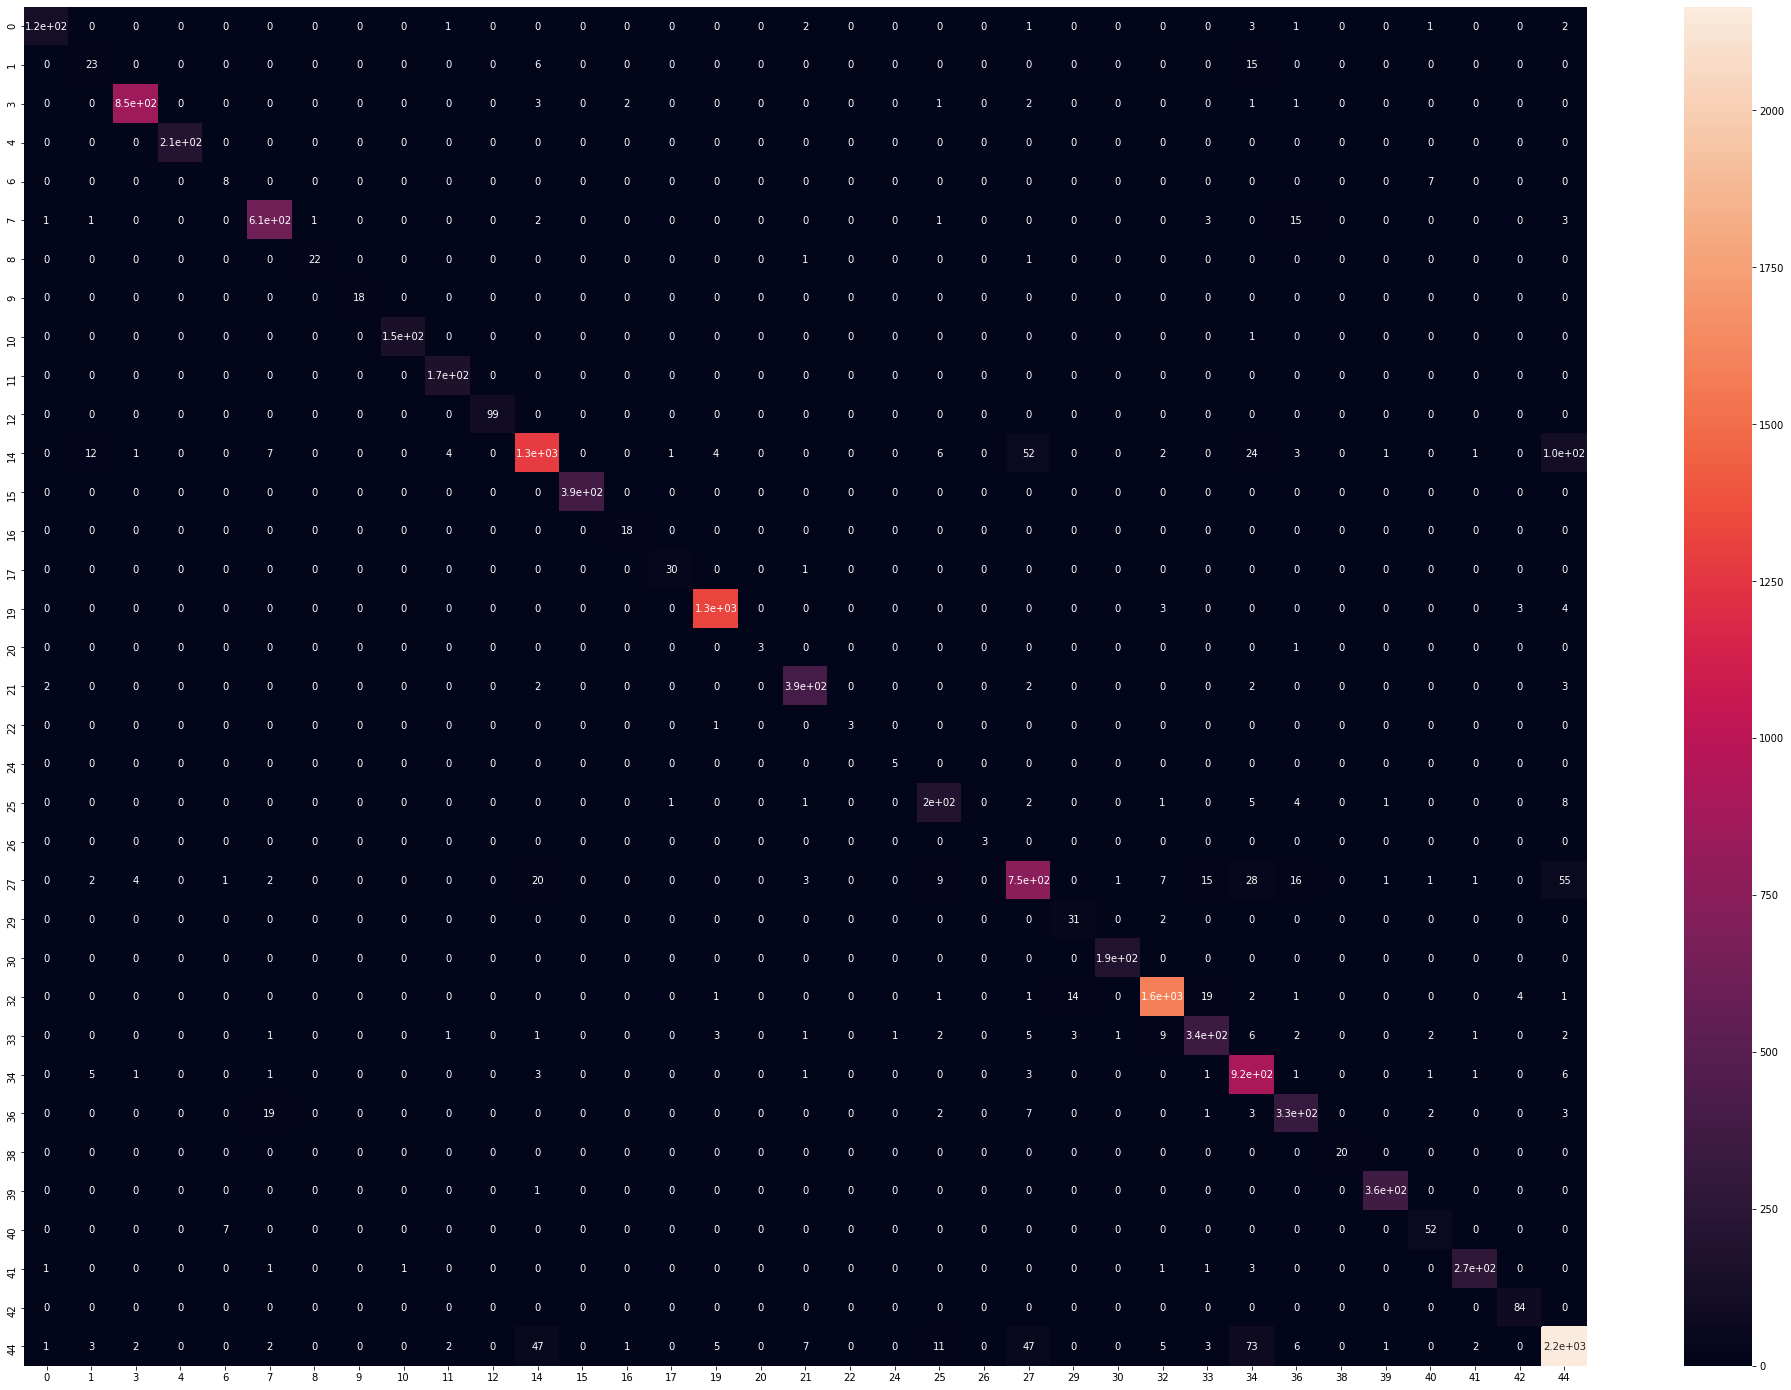

In [ ]:
from sklearn.metrics import confusion_matrix

s1 = set(predictions.tolist())
s2 = set(labels.tolist())
s2.update(s1)
l = list(s2)
CM = confusion_matrix(labels, predictions)



import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(CM, index = l,
                  columns = l)
plt.figure(figsize = (35,25))
sn.heatmap(df_cm, annot=True)

sn.set(font_scale=1.4) 


# Improvements

- A character level analysis.

- Find more or better features.

- Find other fetures on which base the weight the loss.


# Report
The train set samples used are both documents and sequences. The val set has been splitted in documents as the test set. According to the experiments the best model is the BiLSTM + CRF, the embedding dim 300, the number of LSTM units 100-200, the batch size 1. The training converges easily with SGD (lr = 0.5), but there's overfitting. Regularization techniques didn't solve the problem. Other techniques implemented after the error analysis improved the f-score on the validation set from 0.77 to 0.80: 12 rule based features and weighted loss.
Results on the test set: 93-94% accuracy, 0.91 f-score.
